In [1]:
import time
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from jax.config import config
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
config.update("jax_enable_x64", True)

<h1>TDSE Forward Problem</h1>

In [2]:
class fourier:

    def __init__(self, L, numx, numfour, seed=None):
        # store model parameters
        self._L = L
        self._numx = numx
        self._numfour = numfour

        # vector of Fourier mode indices
        # fournvec = -numfour,...,0,...,numfour
        fournvec = np.arange(-numfour, numfour + 1)

        # real space grid points (for plotting)
        xvec = np.linspace(-L, L, numx)

        # matrix for converting Fourier representation to real space
        # used like realspacevec = fourspacevec @ fourtox
        self._fourtoxmat = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

        self._numtoepelms = 2 * numfour + 1

        # Toeplitz indexing matrix, used for constructing
        # Toeplitz matrix from a vector which as been set up like:
        # jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
        aa = (-1) * np.arange(0, self._numtoepelms).reshape(self._numtoepelms, 1)
        bb = [np.arange(self._numtoepelms - 1, 2 * self._numtoepelms - 1)]
        self._toepindxmat = np.array(aa + bb)

        self.init('uniform', seed)


    def init(self, dist='uniform', seed=None):
        if dist=='normal':
            self.theta = 0.001 * np.random.default_rng(seed).normal(size=numtoepelms * 2 - 1)  # mean=0, std=1, scale=0.001
        elif dist=='uniform':
            self.theta = 0.02 * np.random.default_rng(seed).random(size=2 * self._numtoepelms - 1) - 0.01  # interval=[-0.01, 0.01)
        else:
            print('Error fourier.init(): Distribution selection not recognized.')


    def tox(self):
        ##################################################
        # Function for transforming the Fourier model
        # into a real space potential
        # - The Fourier model is the Toeplitz representation
        #   of vmat split into real and imaginary parts
        #   and concatenated together,
        ##################################################
        thetaR = self.theta[:self._numtoepelms]
        thetaI = jnp.concatenate((jnp.array([0.0]), self.theta[numtoepelms:]))
        thetacomplex = thetaR + 1j * thetaI

        potentialfourier = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(thetacomplex[1:(self._numfour + 1)])), thetacomplex[:(self._numfour + 1)]])

        potentialreal = jnp.real(potentialfourier @ self._fourtoxmat)

        return potentialreal


    def tovmat(self):
        #################################################
        # theta is a vector containing the concatenation
        # of the real and imaginary parts of vmat
        # its size should be
        # 2 * numtoepelms - 1 = 4 * numfour + 1
        #################################################
        # to use theta we need to first recombine the real
        # and imaginary parts into a vector of complex values
        vtoephatR = self.theta[:self._numtoepelms]
        vtoephatI = jnp.concatenate((jnp.array([0.0]), self.theta[self._numtoepelms:]))
        vtoephat = vtoephatR + 1j * vtoephatI

        # construct vmathat from complex toeplitz vector
        vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[self._toepindxmat]

        return vmathat


    def thetatovmat(theta, *args):
        #################################################
        # theta is a vector containing the concatenation
        # of the real and imaginary parts of vmat
        # its size should be
        # 2 * numtoepelms - 1 = 4 * numfour + 1
        #################################################
        L, numx, numfour = args
        numtoepelms = 2 * numfour + 1

        # Toeplitz indexing matrix, used for constructing
        # Toeplitz matrix from a vector which as been set up like:
        # jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
        aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
        bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
        toepindxmat = np.array(aa + bb)

        # to use theta we need to first recombine the real
        # and imaginary parts into a vector of complex values
        vtoephatR = theta[:numtoepelms]
        vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
        vtoephat = vtoephatR + 1j * vtoephatI

        # construct vmathat from complex toeplitz vector
        vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

        return vmathat


    def grad(self):
        # this code computes the real part of \nabla_\theta H(\theta)
        myeye = jnp.eye(self._numtoepelms)
        wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
        ctrmatsR = wsR[self._toepindxmat]

        # this code computes the imaginary part of \nabla_\theta H(\theta)
        wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
        wsI = wsI[1:, :]
        wsI = wsI.T
        ctrmatsI = wsI[self._toepindxmat]

        # concatenate the real and imaginary parts of
        gradmat = jnp.concatenate([ctrmatsR, ctrmatsI], axis=2)

        return gradmat


    def thetatograd(_, *args):
        L, numx, numfour = args
        numtoepelms = 2 * numfour + 1

        # Toeplitz indexing matrix, used for constructing
        # Toeplitz matrix from a vector which as been set up like:
        # jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
        aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
        bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
        toepindxmat = np.array(aa + bb)

        # this code computes the real part of \nabla_\theta H(\theta)
        myeye = jnp.eye(numtoepelms)
        wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
        ctrmatsR = wsR[toepindxmat]

        # this code computes the imaginary part of \nabla_\theta H(\theta)
        wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
        wsI = wsI[1:, :]
        wsI = wsI.T
        ctrmatsI = wsI[toepindxmat]

        # concatenate the real and imaginary parts of
        gradmat = jnp.concatenate([ctrmatsR, ctrmatsI], axis=2)

        return gradmat

In [3]:
# size of spatial domain
L = 15.0

# number of real space grid points (for plotting)
numx = 1025

# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
numfour = 32  # 64

# number of Toeplitz elements in the Fourier representation
numtoepelms = 2 * numfour + 1

# set number of time steps
# trajectory's length = numts + 1
numts = 20  # 20

# set time-step size
dt = 1e-2  # 1e-2

# print computational environment variables to stdout
print('L =', L)
print('numx =', numx)
print('numfour =', numfour)
print('numts =', numts)
print('dt =', dt)

L = 15.0
numx = 1025
numfour = 32
numts = 20
dt = 0.01


In [4]:
###############################################################
# utilities
###############################################################

# vector of Fourier mode indices
# fournvec = -numfour,...,0,...,numfour
fournvec = np.arange(-numfour, numfour + 1)

# matrix for converting Fourier representation to real space
# used like realspacevec = fourspacevec @ fourtox
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

In [5]:
###############################################################
# Set trim of real space region
###############################################################

trim = np.where(xvec >= -10)[0][0]  # 125
print('trim =', trim)
print('')  # blank line

trim = 171



In [6]:
# ###############################################################
# # Toeplitz indexing matrix
# ###############################################################
#
# # Toeplitz indexing matrix, used for constructing Toeplitz matrix
# # from a vector setup like:
# # jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
# aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
# bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
# toepindxmat = np.array(aa + bb)
# # print(toepindxmat.shape)

In [7]:
# ###############################################################
# # function for transforming theta to a real space potential
# ###############################################################
#
# def thetatoreal(theta):
#     ##################################################
#     # this function is used to transform theta, which
#     # is the Toeplitz representation of vmat that has
#     # also been split into real and imaginary parts
#     # and concatenated together, into a real space
#     # potential
#     ##################################################
#     thetaR = theta[:numtoepelms]
#     thetaI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
#     thetacomplex = thetaR + 1j * thetaI
#     potentialfourier = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(thetacomplex[1:(numfour + 1)])), thetacomplex[:(numfour + 1)]])
#     potentialreal = potentialfourier @ fourtox
#     return potentialreal

---
**Potential Function**

In [8]:
# define potential for generating training data

def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    return 0.5 * z**2

    # symmetric double well potential
    # return 2.5e-3 * (z ** 2 - 25) ** 2

    # asymmetric double well potential
    # c0 = 4.35
    # c1 = 9.40e-1
    # c2 = -3.56e-1
    # c3 = -4.66e-2
    # c4 = 1.46e-2
    # c5 = 6.76e-4
    # c6 = -1.26e-4
    # c7 = -5.43e-6
    # c8 = 4.12e-7
    # c9 = 1.65e-8
    # x = z + 0.8
    # return 0.5 * (c0 + c1 * x + c2 * x ** 2 + c3 * x ** 3 + c4 * x ** 4 + c5 * x ** 5 + c6 * x ** 6 + c7 * x ** 7 + c8 * x ** 8 + c9 * x ** 9)

    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# true potential on real space grid (for plotting)
vtruexvec = v(xvec)

# compute the potential operator matrix, vmat
vtruetoep = []
for thisfourn in range(numtoepelms):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vtruetoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

vtruetoep = jnp.array(vtruetoep)


In [9]:
# select the model of the potential
model = fourier

# create a model class object and save as thetatrue
thetatrue = model(L, numx, numfour)

# load thetatrue with the true potential represented in
# terms of the model being used.
# - here we are using the fourier model
thetatrue.theta = jnp.concatenate((vtruetoep.real, vtruetoep[1:].imag))
# thetatrue = jnp.concatenate((vtruetoep.real, vtruetoep[1:].imag))

print('Shape thetatrue:', thetatrue.theta.shape)

Shape thetatrue: (129,)


l2 error vtruexvecrec: 0.5079525437523776
l-inf error vtruexvecrec: 0.040670882387431107


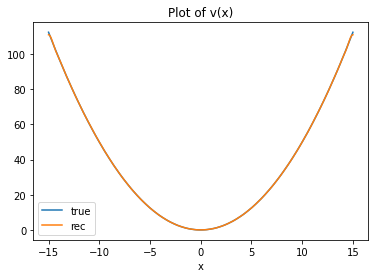

In [10]:
# thetatrue = jnp.concatenate((vtruetoep.real, vtruetoep[1:].imag))
# vtruemat = sl.toeplitz(r=vtruetoep, c=np.conj(vtruetoep))
# vtruexvecrec = thetatoreal(thetatrue)
# print('l2 error vtruexvecrec:', nl.norm(vtruexvecrec[trim:-trim] - vtruexvec[trim:-trim]))
# print('l-inf error vtruexvecrec:', np.amax(np.abs(vtruexvecrec[trim:-trim] - vtruexvec[trim:-trim])))

print('l2 error vtruexvecrec:', nl.norm(thetatrue.tox()[trim:-trim] - vtruexvec[trim:-trim]))
print('l-inf error vtruexvecrec:', np.amax(np.abs(thetatrue.tox()[trim:-trim] - vtruexvec[trim:-trim])))

# plot true potential
plt.plot(xvec, vtruexvec, label='true')
plt.plot(xvec, thetatrue.tox(), label='rec')
plt.title('Plot of v(x)')
plt.xlabel('x')
plt.legend()
plt.show()

---
**Initial States - a0**

Number of a0 states: 1


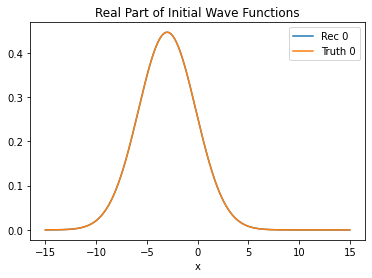

L2 Error of reconstructed psi0:
7.476210590807997e-05
L-infinity Error psi0:
3.137317008559103e-05


In [11]:
# define initial state functions
def psi0_0(x):
    return 10 * np.exp(-((x + 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return 10 * np.exp(-((x + 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-((x - 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_2(x):
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25
    return np.exp(-((x - 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    # a weird non-symmetric wavefunction
    # return np.abs(np.sin((0.15*x - 0.5)**2))
    return np.exp(-((x + 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x + 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-((x - 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 11)**2) * (2.0 / np.pi)**0.25

def psi0_5(x):
    return np.exp(-((x + 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 11)**2) * (2.0 / np.pi)**0.25


# function for normalizing initial wave functions
# and transforming them to the Fourier representation
def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    a0raw = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        a0raw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(a0raw[1:])), a0raw])
    a0 = jnp.array(a0)
    normpsi0x = norm_psi0fn(xvec)

    return a0, normpsi0x


# generate initial state vector
# pick initial un-normalized wave functions
psi0fnvec = [psi0_0]  # [psi0_0, psi0_1, psi0_2, psi0_3]

# make initial states, a0, with mka0
a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)

a0vec = jnp.array(a0vec)
normpsi0xvec = np.array(normpsi0xvec)
normpsi0recxvec = np.array(normpsi0recxvec)

print('Number of a0 states:', a0vec.shape[0])

# plot the real part of the normalized psi0
for i in range(len(a0vec)):
    plt.plot(xvec, normpsi0recxvec[i].real, label=f'Rec {i}')
    plt.plot(xvec, normpsi0xvec[i].real, label=f'Truth {i}')
plt.title('Real Part of Initial Wave Functions')
plt.xlabel('x')
plt.legend()
plt.show()

print('L2 Error of reconstructed psi0:', nl.norm(normpsi0recxvec - normpsi0xvec), sep='\n')
print('L-infinity Error psi0:', np.max(np.abs(normpsi0recxvec - normpsi0xvec)), sep='\n')

---
<h3>Foward Propagation - Construct the Training Data</h3>

In [12]:
# make kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))
print('Shape kmat', kmat.shape)

# Hamiltonian operator with true potential
# in the Fourier representation
hmattrue = kmat + thetatrue.tovmat()
# hmattrue = kmat + vtruemat
print('Shape hmattrue', hmattrue.shape)

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = jnl.eigh(hmattrue)
print('Done with eigen-decomposition')

# compute propagator matrix
propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T
print('Shape propatrue', propatrue.shape)

# propagate system starting from initial "a" state
# using the Hamiltonian constructed from the true potential
# (used for generating training data)
amattruevec = []
for thisa0 in a0vec:
    tempamat = [thisa0.copy()]
    for _ in range(numts):
        tempamat.append(propatrue @ tempamat[-1])

    amattruevec.append(tempamat)

amattruevec = jnp.array(amattruevec)

print('Done propagating.')

Shape kmat (65, 65)
Shape hmattrue (65, 65)
Done with eigen-decomposition
Shape propatrue (65, 65)
Done propagating.


---
<h3>Inverse Problem - Adjoint Method</h3>

In [13]:
def fourwaveobject(theta):
    # #################################################
    # # theta is a vector containing the concatenation
    # # of the real and imaginary parts of vmat
    # # its size should be
    # # 2 * numtoepelms - 1 = 4 * numfour + 1
    # #################################################
    #
    # # to use theta we need to first recombine the real
    # # and imaginary parts into a vector of complex values
    # vtoephatR = theta[:numtoepelms]
    # vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    # vtoephat = vtoephatR + 1j * vtoephatI
    #
    # # construct vmathat from complex toeplitz vector
    # vhatmat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # construct vmathat using the model class method
    # .tovmat(), theta is what ever the model class
    # uses as the data structure to store the potential
    # any other arguments are what is required to define
    # the model
    vhatmat = model.thetatovmat(theta, L, numx, numfour)

    # **************************************************
    # the code enclosed by ' # ****' is the same regardless
    # of what model you use
    # **************************************************
    # Construct Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    # forward propagation loop
    ahatmatvec = []
    for r in range(a0vec.shape[0]):
        thisahatmat = [a0vec[r].copy()]

        # propagate system starting from initial "a" state
        for _ in range(numts):
            # propagate the system one time-step
            thisahatmat.append(propahat @ thisahatmat[-1])

        ahatmatvec.append(thisahatmat)

    # transform python list to a jax.numpy array
    ahatmatvec = jnp.array(ahatmatvec)

    # compute objective functions
    resid = ahatmatvec - amattruevec

    # as per our math, we need to take the real part of
    # the objective
    rtnobjvec = jnp.real(0.5 * jnp.sum(jnp.conj(resid) * resid, axis=1))
    rtnobj = jnp.sum(rtnobjvec)
    # **************************************************

    return rtnobj


# jit wavefnobject()
jitfourwaveobject = jax.jit(fourwaveobject)

# precompile jitwavefnobject with Chebyshev representation
# of the true potential
# JAX can only deal with JAX, NumPy, Python or list type objects
# so to get around this, we are going to pass the data structure which
# stores the model's representation of the potential, i.e, theta
# print('jitchebwaveobject(thetatrue) =', fourwaveobject(thetatrue))
print('jitchebwaveobject(thetatrue.theta) =', jitfourwaveobject(thetatrue.theta))

jitchebwaveobject(thetatrue.theta) = 0.0


In [14]:
jitfourwaveobjectjax = jax.jit(jax.grad(fourwaveobject))

# precompile chebwavegradsjax with Chebyshev representation
# of the true potential
print('nl.norm(jitchebwavegradsjax(vtruecheb)) =', nl.norm(jitfourwaveobjectjax(thetatrue.theta)))

nl.norm(jitchebwavegradsjax(vtruecheb)) = 0.0


---
**Adjoint Method**

In [15]:
###############################################################
# adjoint method for computing gradient
###############################################################

# function for computing gradients using adjoint method
def fourwavegradsadj(theta):
    #################################################
    # theta is a vector containing the concatenation
    # of the real and imaginary parts of vmat
    # its size should be
    # 2 * numtoepelms - 1 = 4 * numfour + 1
    #################################################

    # # to use theta we need to first recombine the real
    # # and imaginary parts into a vector of complex values
    # vtoephatR = theta[:numtoepelms]
    # vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    # vtoephat = vtoephatR + 1j * vtoephatI
    #
    # # construct vmathat from complex toeplitz vector
    # vhatmat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # construct vmathat using the model class method
    # .tovmat(), theta is what ever the model class
    # uses as the data structure to store the potential
    # any other arguments are what is required to define
    # the model
    vhatmat = model.thetatovmat(theta, L, numx, numfour)

    # **************************************************
    # the code enclosed by ' # ****' is the same regardless
    # of what model you use
    # **************************************************
    # Construct Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)

    # compute propagator matrices
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    proplam = jnp.transpose(jnp.conjugate(propahat))

    # forward propagation
    ahatmatvec = []
    lammatvec = []
    for r in range(a0vec.shape[0]):
        ####################################################
        # build ahatmat, i.e., forward propagate of the
        # system with theta starting from a given initial
        # state a0
        ####################################################

        # initialize thisahatmat with given a0 state
        thisahatmat = [a0vec[r].copy()]

        # forward propagate of the system with theta
        for i in range(numts):
            # propagate the system one time-step and store the result
            thisahatmat.append(propahat @ thisahatmat[-1])

        # store compute ahatmat
        ahatmatvec.append(jnp.array(thisahatmat))

        ####################################################
        # build lammat
        # \lambda_N = (\hat{a}_N - a_N)
        # \lambda_j = (\hat{a}_j - a_j) + [\nabla_a \phi_{\Delta t} (a_j; \theta)]^\dagger \lambda_{j+1}
        # [\nabla_a \phi_{\Delta t} (a_j; \theta)]^\dagger = [exp{-i H \Delta t}]^\dagger
        ####################################################

        # compute the error of ahatmatvec[r] WRT amattruevec[r]
        thisahatmaterr = ahatmatvec[r] - amattruevec[r]

        # initialize thislammat
        thislammat = [thisahatmaterr[-1]]

        # build lammat backwards then flip
        for i in range(2, numts + 2):
            thislammat.append(thisahatmaterr[-i] + proplam @ thislammat[-1])

        # flip thislammat, make into a jax array, and add to lammatvec
        lammatvec.append(jnp.flipud(jnp.array(thislammat)))

    # make lists into JAX array object
    ahatmatvec = jnp.array(ahatmatvec)
    lammatvec = jnp.array(lammatvec)
    # **************************************************


    ####################################################
    # the remainder of this function is for computing
    # the gradient of the exponential matrix
    # - The blocks of code surrounded by '# ***...'
    #   are common to the adjoint method when using
    #   the Fourier basis to discretize, regardless
    #   of the model
    ####################################################

    # **************************************************
    # the code enclosed by ' # ****' is the same regardless
    # of what model you use
    # - Given the diagonalization H = U D U^\dagger
    # - The final gradient \nabla_\theta \phi(a;\theta)
    #   is Q = U M U^\dagger, where M = A (*) mask
    #   and A = U^\dagger [\nabla_\theta H = \nabla_\theta model of vhatmat or v(x)] U
    # **************************************************
    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    # get the gradient of the model, function expects
    # model.thetatograd(theta, *args), where args is
    # what ever elements the model needs to be fully defined
    # - here, our model is the Fourier basis
    modelgrad = model.thetatograd(theta, L, numx, numfour)
    # this line computes U^\dagger \nabla_\theta H(\theta) U
    prederivamat = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, modelgrad, stthat)

    # this line computes
    # M_{i l} = A_{i l} (exp(D_{i i}) or (exp(D_{i i}) - exp(D_{l l}))/(D_{i i} - D_{l l}))
    derivamat = prederivamat * jnp.expand_dims(mask, 2)

    # this line computes Q = U M U^\dagger
    alldmat = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stthat, derivamat, stthat.conj().T)

    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('bij,ajk,bik->a', jnp.conj(lammatvec[:, 1:]), alldmat, ahatmatvec[:, :-1]))
    # **************************************************

    return gradients


# jist adjgrads
jitfourwavegradsadj = jax.jit(fourwavegradsadj)

# precompile chebwavegradsjax with Chebyshev representation
# of the true potential
print('nl.norm(jitchebwavegradsadj(vtruecheb)) =', nl.norm(jitfourwavegradsadj(thetatrue.theta)))

nl.norm(jitchebwavegradsadj(vtruecheb)) = 4.0690680447589486e-15


In [16]:
###############################################################
# Evaluate adjoint gradient
# - generate a theta of random values
# - compute the adjoint and JAX gradients
# - compute the error of the adjoint gradient WRT the JAX
#   gradient
###############################################################

# number of iterations
numitr = 10

# evaluate the gradients
totalerr = 0
for i in range(numitr):
    # generate a theta with random values
    # thisthetarnd = np.random.default_rng().normal(size=numcheb + 1) * 10
    thisthetarnd = 10.0 * np.random.default_rng().uniform(size=2*numtoepelms - 1) - 5.0

    # compute the gradient
    t1 = time.time()
    adjgrad = jitfourwavegradsadj(thisthetarnd)
    t2 = time.time()
    jaxgrad = jitfourwaveobjectjax(thisthetarnd)
    t3 = time.time()

    # results
    print("adj time =", t2 - t1)
    print("jax time =", t3 - t2)
    thiserr = nl.norm(adjgrad - jaxgrad)
    totalerr += thiserr
    print("error =", thiserr)

print('Mean error:', totalerr/numitr)

adj time = 0.003297567367553711
jax time = 0.011578559875488281
error = 5.939891963158114e-14
adj time = 0.0036160945892333984
jax time = 0.010764360427856445
error = 2.3888753165972203e-13
adj time = 0.0035009384155273438
jax time = 0.010738849639892578
error = 8.035488545046966e-14
adj time = 0.0034966468811035156
jax time = 0.010754108428955078
error = 8.69867899704462e-14
adj time = 0.0028083324432373047
jax time = 0.01148223876953125
error = 1.1326621040699334e-13
adj time = 0.0028514862060546875
jax time = 0.011506795883178711
error = 1.132686842217485e-13
adj time = 0.0029098987579345703
jax time = 0.011582136154174805
error = 7.469187832326388e-14
adj time = 0.0027985572814941406
jax time = 0.011485815048217773
error = 2.6175246743239788e-14
adj time = 0.0028328895568847656
jax time = 0.011531591415405273
error = 4.3756706152888054e-14
adj time = 0.0027894973754882812
jax time = 0.011485576629638672
error = 5.976178564315705e-14
Mean error: 8.965486382035095e-14


---

In [32]:
seed = 1234  # set to None for random initialization
thetarnd = 10.0 * np.random.default_rng(seed).uniform(size=2*numtoepelms - 1) - 5.0

In [33]:
thetahat = so.minimize(fun=jitfourwaveobject, x0=thetarnd, jac=jitfourwavegradsadj, tol=1e-12, options={'maxiter': 4000, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 1795
         Function evaluations: 1980
         Gradient evaluations: 1968


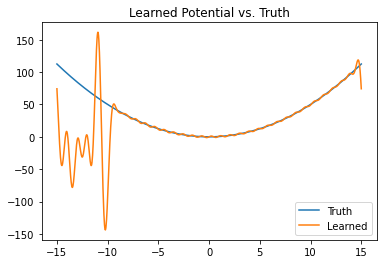

In [35]:
# plot learned vs true
plt.plot(xvec, vtruexvec, label='Truth')
# plt.plot(xvec, thetatoreal(thetarnd), label='Initial')
plt.plot(xvec, thetatoreal(thetahat), label='Learned')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()